In [2]:
import sys
sys.path.append("../")

import math
import torch
import torch_geometric as pyg
import numpy as np
from models.GLASE_unshared_normalized import gLASE 
from models.RDPG_GD import RDPG_GD_Armijo, coordinate_descent
from models.SVD_truncate import embed_scipy
from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph, erdos_renyi_graph
from graspologic.embed import AdjacencySpectralEmbed 
import matplotlib.pyplot as plt
import seaborn as sns
from training.get_init import get_x_init


def ground_truth_adjacency_matrix(n,p):
    for row_id, row in enumerate(np.array(p)):
        for item_id, item in enumerate(row):
            if item_id == 0:
                A_row = np.ones([n[row_id],n[item_id]])*item
            else:
                A_row = np.hstack((A_row,np.ones([n[row_id],n[item_id]])*item))
                
        if row_id == 0:
            A = A_row
        else:
            A = np.vstack((A,A_row))
    return A

/Users/sofiaperez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sofiaperez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sofiaperez/.pyenv/versions/3.11.3/lib/python3.11/si

# SBM-5 - 5 steps

Loss GLASE shared weights (5 layers):  tensor(1406.2123)
Loss Graspologic ASE:  1984.3784
Loss RDPG SVD Truncate:  1985.1708


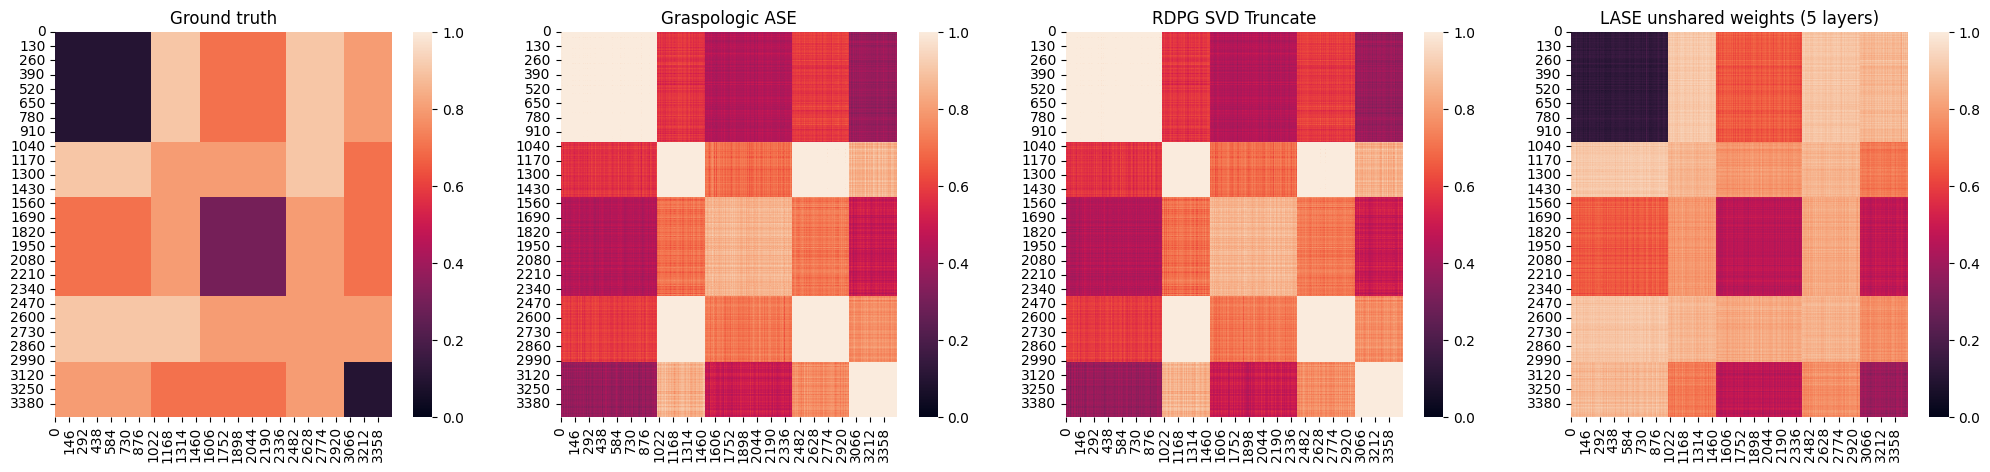

In [4]:
d = 5
gd_steps = 5
device = 'cpu'

glase = gLASE(d, d, gd_steps)
glase.load_state_dict(torch.load('../saved_models/glase_unshared_d5_normalized_unbalanced_initx.pt'))
glase.to(device)
glase.eval()

num_nodes = 3500
n = [1000, 500, 900, 600, 500]
p = [
    [0.1, 0.9, 0.7, 0.9, 0.8],
    [0.9, 0.8, 0.8, 0.9, 0.7],
    [0.7, 0.8, 0.3, 0.8, 0.7],
    [0.9, 0.9, 0.8, 0.8, 0.8],
    [0.8, 0.7, 0.7, 0.8, 0.1],
]

## GROUND TRUTH
A = ground_truth_adjacency_matrix(n,p)

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
q = torch.Tensor([[1,-1,-1,-1,-1]])
Q=torch.diag(q[0]).to(device)

x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)

x_glase = glase(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss GLASE shared weights ({gd_steps} layers): ", loss)
x_glase = x_glase.to('cpu')

# ## ASE EMBEDDINGS
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(adj_matrix)
x_ase = torch.from_numpy(x_ase)
loss = np.linalg.norm((x_ase@x_ase.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss Graspologic ASE: ", loss)

# x_gd, cost_gd, iter = RDPG_GD_Armijo(x, edge_index, mask)
# x_gd = x_gd.to('cpu')
# loss = torch.norm((x_gd@x_gd.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
# print("Loss RDPG GD Armijo: ", loss)
# print("Armijo iterations: ", iter)

x_svd = embed_scipy(edge_index,d)
loss = np.linalg.norm((x_svd@x_svd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss)

# x_cgd = coordinate_descent(edge_index, mask, d)
# loss = np.linalg.norm((x_cgd@x_cgd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
# print("Loss Coordinate Gradient Descent: ", loss)


fig, axes = plt.subplots(1, 4, figsize =(25,5))
axes[0].set_title('Ground truth')
sns.heatmap(A, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True)
axes[1].set_title('Graspologic ASE')
sns.heatmap(x_ase@x_ase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)
axes[2].set_title('RDPG SVD Truncate')
sns.heatmap(x_svd@x_svd.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True)
# # axes[1].set_title(f'Coordinate Gradient Descent')
# # sns.heatmap(x_cgd@x_cgd.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)
# # axes[2].set_title('RDPG GD Armijo (random input)')
# # sns.heatmap(x_gd@x_gd.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True)
axes[3].set_title(f'LASE unshared weights ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[3], vmin=0.0, vmax=1.0, cbar=True)
plt.show()

# SBM-5 - 10 steps

Loss GLASE shared weights (10 layers):  tensor(1411.8085)
Loss Graspologic ASE:  1984.5823
Loss RDPG SVD Truncate:  1985.3694


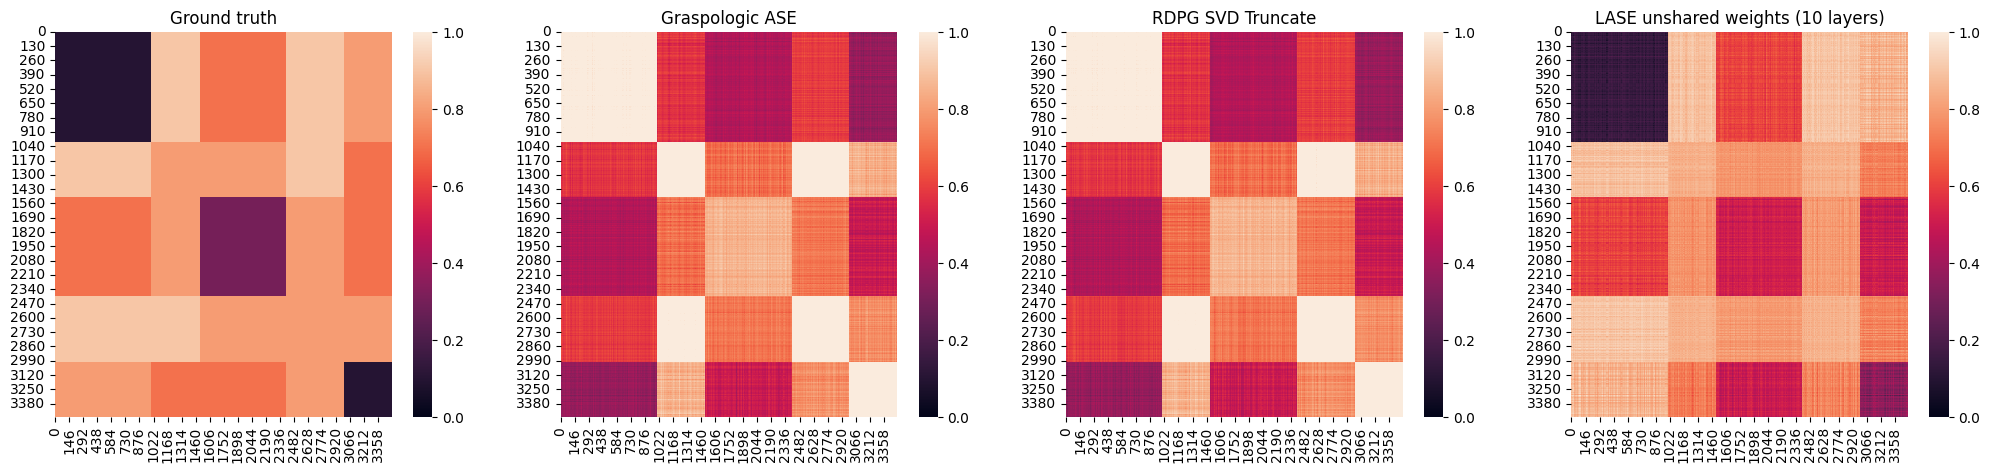

In [5]:
d = 5
gd_steps = 10
device = 'cpu'

glase = gLASE(d, d, gd_steps)
glase.load_state_dict(torch.load('../saved_models/glase_unshared_d5_normalized_unbalanced_initx_10steps.pt'))
glase.to(device)
glase.eval()

num_nodes = 3500
n = [1000, 500, 900, 600, 500]
p = [
    [0.1, 0.9, 0.7, 0.9, 0.8],
    [0.9, 0.8, 0.8, 0.9, 0.7],
    [0.7, 0.8, 0.3, 0.8, 0.7],
    [0.9, 0.9, 0.8, 0.8, 0.8],
    [0.8, 0.7, 0.7, 0.8, 0.1],
]

## GROUND TRUTH
A = ground_truth_adjacency_matrix(n,p)

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
q = torch.Tensor([[1,-1,-1,-1,-1]])
Q=torch.diag(q[0]).to(device)

x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)

x_glase = glase(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss GLASE shared weights ({gd_steps} layers): ", loss)
x_glase = x_glase.to('cpu')

# ## ASE EMBEDDINGS
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(adj_matrix)
x_ase = torch.from_numpy(x_ase)
loss = np.linalg.norm((x_ase@x_ase.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss Graspologic ASE: ", loss)

# x_gd, cost_gd, iter = RDPG_GD_Armijo(x, edge_index, mask)
# x_gd = x_gd.to('cpu')
# loss = torch.norm((x_gd@x_gd.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
# print("Loss RDPG GD Armijo: ", loss)
# print("Armijo iterations: ", iter)

x_svd = embed_scipy(edge_index,d)
loss = np.linalg.norm((x_svd@x_svd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss)

# x_cgd = coordinate_descent(edge_index, mask, d)
# loss = np.linalg.norm((x_cgd@x_cgd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
# print("Loss Coordinate Gradient Descent: ", loss)


fig, axes = plt.subplots(1, 4, figsize =(25,5))
axes[0].set_title('Ground truth')
sns.heatmap(A, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True)
axes[1].set_title('Graspologic ASE')
sns.heatmap(x_ase@x_ase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)
axes[2].set_title('RDPG SVD Truncate')
sns.heatmap(x_svd@x_svd.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True)
# # axes[1].set_title(f'Coordinate Gradient Descent')
# # sns.heatmap(x_cgd@x_cgd.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)
# # axes[2].set_title('RDPG GD Armijo (random input)')
# # sns.heatmap(x_gd@x_gd.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True)
axes[3].set_title(f'LASE unshared weights ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[3], vmin=0.0, vmax=1.0, cbar=True)
plt.show()

# SBM-5 - 20 steps